# Permeation regimes

**Objectives**

- Implement dissociation and recombination fluxes
- Identify different hydrogen permeation regimes for gas driven permeation problems

In the previous permeation tutorial, the concentration on the upstream surface was enforced with Sievert's law of solubility. However, this law is valid only for _diffusion limited_ permeation.
This is a particular regime where the overall transport of hydrogen from the gas phase to the downstream volume is limited by the diffusion in the bulk material. In some conditions, the transport is limited by the surface effects. This is the _surface limited_ regime.

In this tutorial, we'll implement dissociation and recombination fluxes on the surfaces and show the transition from one regime to another, and explore the validity of Sievert's law.

Let's start by making a parametric FESTIM model taking as parameters the size of the domain, the upstream pressure, the surface rate coefficients, and the diffusivity.

## Implementation

In [1]:
import festim as F
import numpy as np


def compute_permeation_flux(L, P_up, K_r_, K_d, D):
    my_model = F.Simulation(log_level=40)

    my_model.mesh = F.MeshFromVertices(vertices=np.linspace(0, L, num=10))

    my_model.materials = F.Material(id=1, D_0=D, E_D=0)

    my_model.boundary_conditions = [
        F.DissociationFlux(Kd_0=K_d, E_Kd=0, P=P_up, surfaces=1),
        F.RecombinationFlux(Kr_0=K_r_, E_Kr=0, order=2, surfaces=[1, 2]),
    ]

    my_model.T = 300  # ignored here

    my_model.settings = F.Settings(
        absolute_tolerance=1e-8,
        relative_tolerance=1e-10,
        transient=True,
        final_time=400,
    )

    my_model.dt = F.Stepsize(0.01, stepsize_change_ratio=1.1)

    permeation_flux = F.HydrogenFlux(surface=2)
    surface_concentration = F.TotalSurface(field="solute", surface=1)
    surface_concentration_L = F.TotalSurface(field="solute", surface=2)
    my_model.exports = [
        F.DerivedQuantities(
            [permeation_flux, surface_concentration, surface_concentration_L],
        ),
        F.TXTExport(field=0, filename=f"./pressure_{P_up:.2e}.txt"),
    ]

    my_model.initialise()
    my_model.run()

    return permeation_flux, surface_concentration, surface_concentration_L

/home/remidm/anaconda3/envs/festim-workshop-festim-1/lib/python3.11/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


We can run this model for a range of upstream pressures. We choose arbitrary values for rate coefficients, diffusivities, and length.

In [2]:
K_r = 10
K_d = 100
L = 1
D = 2
fluxes = []
concentrations_0 = []
concentrations_L = []
pressures = np.logspace(-6, 4, num=9)
for P_up in pressures:
    print(f" ---- P = {P_up:.2e} ----")
    flux, c_surf_0, c_surf_L = compute_permeation_flux(L, P_up, K_r, K_d, D)
    fluxes.append(flux)
    concentrations_0.append(c_surf_0)
    concentrations_L.append(c_surf_L)

 ---- P = 1.00e-06 ----
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        4.0e+02 s    Elapsed time so far: 0.3 s
 ---- P = 1.78e-05 ----
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        4.0e+02 s    Elapsed time so far: 0.3 s
 ---- P = 3.16e-04 ----
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        4.0e+02 s    Elapsed time so far: 0.3 s
 ---- P = 5.62e-03 ----
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        4.0e+02 s    Elapsed time so far: 0.3 s
 ---- P = 1.00e-01 ----
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        4.0e+02 s    Elapsed time so far: 0.3 s


## Analysis

### Permeation number

To simplify the analysis, it is useful to define the permeation number $W$ as:

$$
    W = \frac{K_d \ L \ \sqrt{P}}{K_S \ D}
$$

where $K_S = \sqrt{\frac{K_d}{K_r}}$ is the solubility.

In [ ]:
def permeation_number(P):
    K_S = (K_d/K_r)**0.5
    return K_d * L * P**0.5 / (K_S * D)


### Permeation flux as a function of time

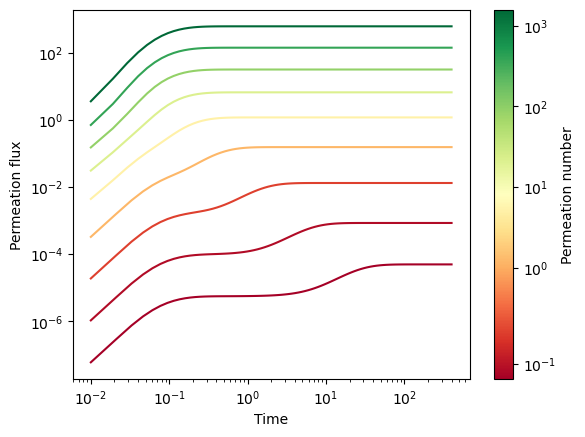

In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

norm = mcolors.SymLogNorm(linthresh=0.5, vmin=permeation_number(pressures[0]), vmax=permeation_number(pressures[-1]))
cmap = plt.cm.RdYlGn

for i, P in enumerate(pressures):
    plt.loglog(
        fluxes[i].t,
        np.abs(fluxes[i].data),
        color=cmap(norm(permeation_number(P))),
    )

plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    label="Permeation number",
    ax=plt.gca(),
)
plt.xlabel("Time")
plt.ylabel("Permeation flux")
plt.show()

### Concentration profiles

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


def animate_concentration_profile(P):
    data = np.genfromtxt(f"pressure_{P:.2e}.txt", delimiter=",", skip_header=1)

    x = data[:, 0]
    # order x
    order = np.argsort(x)
    x = x[order]

    fig, ax = plt.subplots()
    (line1,) = ax.plot([], [], lw=2, color="black")

    def init():
        line1.set_data([], [])
        ax.set_title(f"Hydrogen concentration profile at P = {P:.2e} Pa")
        ax.set_xlim(0, L)
        ax.set_ylim(bottom=0, top=np.max(data[:, 1:]) * 1.1)
        ax.set_xlabel(r"x")
        ax.set_ylabel(r"H concentration")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        return [line1]

    def animate(i):
        c = data[:, i + 1][order]
        line1.set_data(x, c)
        return [line1]

    # Call the animator
    ani = animation.FuncAnimation(
        fig, animate, init_func=init, frames=data.shape[1] - 1, interval=50, blit=True
    )

    plt.close(fig)

    return HTML(ani.to_jshtml())

In [6]:
animate_concentration_profile(pressures[0])

In [7]:
animate_concentration_profile(pressures[-4])

### Permeation flux as a function of pressure

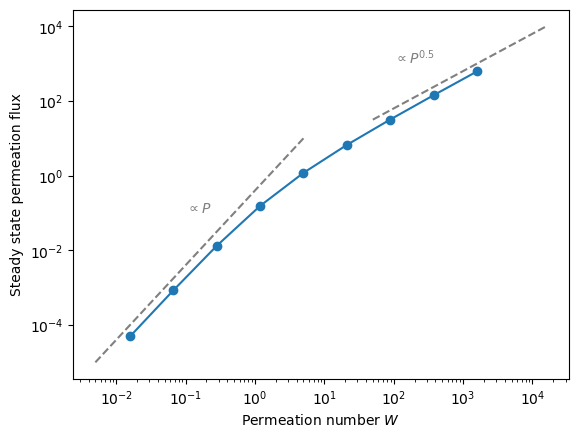

In [23]:
steady_state_fluxes = np.abs([flux.data[-1] for flux in fluxes])

plt.plot(permeation_number(pressures), steady_state_fluxes, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Permeation number $W$")
plt.ylabel("Steady state permeation flux")

Ps_linear = np.logspace(-7, -1)
Ps_squared = np.logspace(1, 6)
plt.plot(permeation_number(Ps_linear), Ps_linear * 100, linestyle="--", color="gray")
plt.plot(permeation_number(Ps_squared), Ps_squared**0.5 * 10, linestyle="--", color="gray")

plt.annotate(r"$\propto P$", (1e-1, 1e-1), color="gray")
plt.annotate(r"$\propto P^{0.5}$", (1e2, 1e3), color="gray")
plt.show()

## Validity of hypotheses on surface concentrations

At high permeation numbers, the concentration on the upstream surface is very rapidly equal to Sievert's law.
However at lower permeation numbers, it takes longer for the upstream concentration to reach steady state, and this steady state isn't even exactly equal to Sievert's law.

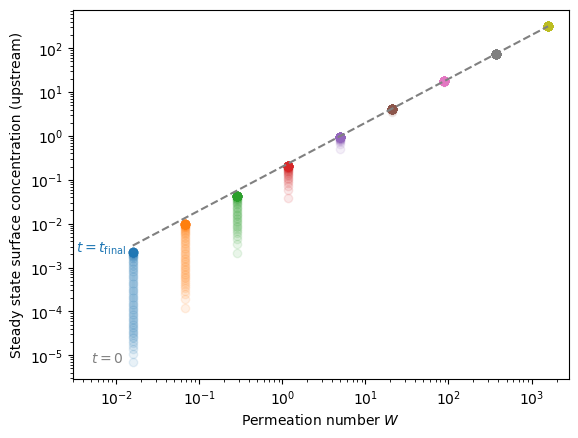

In [29]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Permeation number $W$")
plt.ylabel("Steady state surface concentration (upstream)")

plt.plot(
    permeation_number(pressures), (np.array(pressures) * K_d / K_r) ** 0.5, linestyle="--", color="gray"
)

for i, P in enumerate(pressures):
    if i == 0:
        plt.annotate(
            "$t=0$",
            (permeation_number(P), concentrations_0[i].data[0]),
            xytext=(-30, 0),
            textcoords="offset points",
            color="gray",
        )
        plt.annotate(
            r"$t=t_\mathrm{final}$",
            (permeation_number(P), concentrations_0[i].data[-1]),
            xytext=(-41, 0),
            textcoords="offset points",
            color="tab:blue",
        )
    plt.scatter(
        np.ones_like(concentrations_0[i].data) * permeation_number(P), concentrations_0[i].data, alpha=0.1
    )

plt.annotate("Sievert's law", (1e-4, 1e0), textcoords="data", color="gray")
plt.xlim(left=0.3e-2)
plt.show()

At high permeation numbers (diffusion-limited regime), the concentration on the downstream is negligible compared to the concentration on the upstream surface.

However, at low permeation numbers (surface-limited regime), both concentrations are more and more comparable and assuming $c=0$ on the downstream face isn't valid.

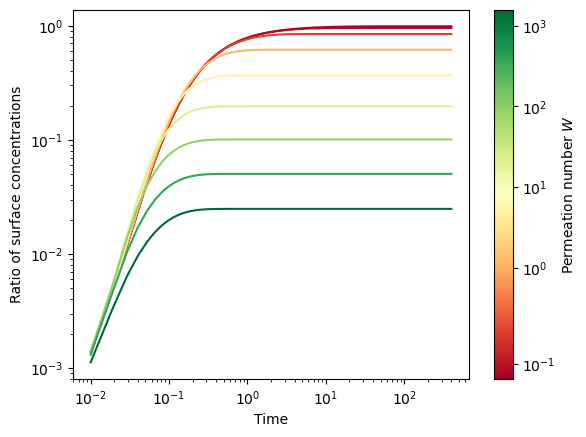

In [44]:
for i, P in enumerate(pressures):
    ratio = np.array(concentrations_L[i].data) / np.array(concentrations_0[i].data)
    plt.loglog(
        concentrations_L[i].t, ratio, label=f"P={P}", color=cmap(norm(permeation_number(P)))
    )

plt.xlabel("Time")
plt.ylabel("Ratio of surface concentrations")
plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Permeation number $W$", ax=plt.gca()
)

plt.show()